In [152]:
# import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Feature exploration

Here we put all the analysis on data on both datasets (like nan values and other things)

In [95]:
# import data
bids = pd.read_csv('Data/facebook/bids.csv')
bidder = pd.read_csv('Data/facebook/train.csv')

Checking for NaN values

In [96]:
for feature in bids.columns:
    if bids[feature].isna().sum() > 0:
        print(f"Feature: {feature} has {len(bids[feature].unique())} nan values")

for feature in bidder.columns:
    if bidder[feature].isna().sum() > 0:
        print(f"Feature: {feature} has {len(bidder[feature].unique())} nan values")

Feature: country has 200 nan values


In [97]:
bids['country'].value_counts()

country
in    1788731
ng     586586
id     453611
tr     319574
us     318103
       ...   
an          2
er          2
gp          2
mh          1
tc          1
Name: count, Length: 199, dtype: int64

We can use mode to infere Nan values beacause it is significantly more common than other values

In [98]:
# fill country with the mode.
bids['country'].fillna(bids['country'].mode()[0], inplace = True) 

Counting unique values

In [99]:
print("Bids shape: ",bids.shape)
for feature in bids.columns:
    if bids[feature].dtype == 'object':
        print(f"Feature: {feature} has {len(bids[feature].unique())} unique values")

Bids shape:  (7656334, 9)
Feature: bidder_id has 6614 unique values
Feature: auction has 15051 unique values
Feature: merchandise has 10 unique values
Feature: device has 7351 unique values
Feature: country has 199 unique values
Feature: ip has 2303991 unique values
Feature: url has 1786351 unique values


In [100]:
print("Bidder shape: ",bidder.shape)
for feature in bidder.columns:
    if bidder[feature].dtype == 'object':
        print(f"Feature: {feature} has {len(bidder[feature].unique())} unique values")

Bidder shape:  (2013, 4)
Feature: bidder_id has 2013 unique values
Feature: payment_account has 2013 unique values
Feature: address has 2013 unique values


`payment_account` and `address` are useless beacause their unique values have the same cardinality of bidder shape, so they cannot help us to identify pattern to distinguish between bot and human bidders. Thus we can drop them.

In [101]:
bidder.drop(['payment_account', 'address'], axis=1, inplace=True)

Encoding data

In [102]:
# encoding 
unique_bidders = pd.concat([bids['bidder_id'], bidder['bidder_id']]).unique()
bidder_mapping = {bidder_id: idx for idx, bidder_id in enumerate(unique_bidders)}
bids['encoded_bidder_id'] = bids['bidder_id'].map(bidder_mapping)
bidder['encoded_bidder_id'] = bidder['bidder_id'].map(bidder_mapping)
bids.drop('bidder_id', axis=1, inplace=True)
bidder.drop('bidder_id', axis=1, inplace=True)

In [103]:
bidder.head(5)

,outcome,encoded_bidder_id
0,0.0,1309
1,0.0,2397
2,0.0,2514
3,0.0,6527
4,0.0,238


In [104]:
bids.head(5)

,bid_id,auction,merchandise,device,time,country,ip,url,encoded_bidder_id
0,0,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,0
1,1,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,1
2,2,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,2
3,3,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,3
4,4,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,4


## Working directly on bidder

### Feature extraction

##### Count the bids for each bidder.
We record the frequency of each bid feature for every bidder.

In [105]:
count_for_bidder = bids.groupby("encoded_bidder_id").nunique()
count_for_bidder.rename(columns = {'bid_id': 'N_bids', 'auction': 'N_auctions', 'merchandise': 'N_merchandise', 'device': 'N_device', 'time': 'N_time', 'country': 'N_country', 'ip': 'N_ip', 'url': 'N_url'},inplace=True)
df_bidder = pd.merge(bidder, count_for_bidder, on='encoded_bidder_id', how='left') # drop the right 

df_bidder.head(5)

,outcome,encoded_bidder_id,N_bids,N_auctions,N_merchandise,N_device,N_time,N_country,N_ip,N_url
0,0.0,1309,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,0.0,2397,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,0.0,2514,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,0.0,6527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,238,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0


##### Ratio metrics

In [106]:
# extract number of bids for something
df_bidder['bids/url'] = df_bidder['N_bids'] / df_bidder['N_url']
df_bidder['bids/ip'] = df_bidder['N_bids'] / df_bidder['N_ip']
df_bidder['bids/auctions'] = df_bidder['N_bids'] / df_bidder['N_auctions']
df_bidder['bids/country'] = df_bidder['N_bids'] / df_bidder['N_country']
df_bidder['bids/device'] = df_bidder['N_bids'] / df_bidder['N_device']
df_bidder = df_bidder.fillna(0) # fill NaN with 0 for bidders that never placed a bid

##### Entropy-Based Feature Engineering for Bidders  

This script calculates entropy-based features to analyze bidder behavior.
 
**Purpose**:
Entropy-based features help distinguish between normal and anomalous bidders. Fraudulent bidders often exhibit predictable patterns (low entropy), while genuine users have diverse, unpredictable behavior (high entropy).  


In [107]:
# calculates entropy for a given list of values
def calculate_entropy(values):
    total = sum(values)
    probabilities = [count / total for count in values]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

# This function computes entropy for a specific feature grouped by encoded_bidder_id.
def compute_entropy_for_feature(df, group_by, feature_name):
    # Count occurrences of the feature per bidder
    temp = df.groupby(group_by)[feature_name].count().reset_index(name=f'{feature_name}_count')
    
    # Compute entropy per bidder
    entropy_df = (
        temp.groupby(group_by[0])[f'{feature_name}_count']
        .apply(calculate_entropy)
        .reset_index(name=f'{feature_name}_entropy')
    )
    
    return entropy_df

# Compute entropy for multiple features
features_to_calculate = ["device", "ip", "auction", "time", "country", "url"]
entropy_dfs = [compute_entropy_for_feature(bids, ['encoded_bidder_id', feature], feature) for feature in features_to_calculate]

# Merge entropy DataFrames
final_entropy_df = entropy_dfs[0]
for df in entropy_dfs[1:]:
    final_entropy_df = final_entropy_df.merge(df, on="encoded_bidder_id", how="left")

df_bidder = df_bidder.merge(final_entropy_df, on="encoded_bidder_id", how="left")
df_bidder.fillna(0)

temp = bids.groupby(['encoded_bidder_id', 'auction'])['url'].count().reset_index(name='url_per_auction_count')

# compute url per auction entropy
bids_per_auction_url_entropy = (
	temp.groupby(['encoded_bidder_id'])['url_per_auction_count']
	.apply(calculate_entropy)
	.reset_index(name='url_entropy_per_auction')
)

df_bidder = pd.merge(df_bidder, bids_per_auction_url_entropy, on='encoded_bidder_id', how='left')
df_bidder.fillna(0)


df_bidder.head(5)

,outcome,encoded_bidder_id,N_bids,N_auctions,N_merchandise,N_device,N_time,N_country,N_ip,N_url,...,bids/auctions,bids/country,bids/device,device_entropy,ip_entropy,auction_entropy,time_entropy,country_entropy,url_entropy,url_entropy_per_auction
0,0.0,1309,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,...,1.333333,4.0,1.714286,3.459148,4.168296,4.053509,4.584963,1.930156,-0.000000,4.053509
1,0.0,2397,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,...,3.000000,3.0,1.500000,0.918296,1.584963,-0.000000,1.584963,-0.000000,0.918296,-0.000000
2,0.0,2514,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,...,1.000000,4.0,2.000000,0.811278,2.000000,2.000000,2.000000,-0.000000,0.811278,2.000000
3,0.0,6527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,0.0,238,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,...,6.739130,77.5,2.924528,4.928988,6.683387,3.564621,7.276124,0.056220,5.101102,3.564621


#### Time difference, concurrent bids, statistical features of bid time difference

In [108]:
# preparing data
df_time = bids.drop(['bid_id', 'country', 'merchandise', 'device', 'url', 'ip', 'auction'],axis=1, inplace=False)
temp = df_time.copy()

# Computing Time Differences Between Consecutive Bids
df_time['difference'] = temp.groupby('encoded_bidder_id').diff() 
df_time.dropna(inplace = True) # we can drop NaN that are the first bid of each bidder

# Counting Concurrent Bids
count_concurrent_bids = df_time[df_time['difference']==0].groupby('encoded_bidder_id').count().drop('time', axis=1)
count_concurrent_bids.rename(columns = {'difference': 'count_concurrent_bids'}, inplace=True)

df_bidder = pd.merge(df_bidder, count_concurrent_bids, on='encoded_bidder_id', how='left').fillna(0)

# Computing Statistical Features of Bid Time Differences
temp = df_time.groupby('encoded_bidder_id')['difference'].describe()
temp.drop(['count'], axis=1, inplace=True)
temp.rename(columns = {'mean': 'mean_difference', 'std': 'std_difference', 'min': 'min_difference', 'max':'max_difference', '50%':'median_difference', '25%':'25_difference', '75%':'75_difference'}, inplace=True)
temp['iqrDiff'] = temp['75_difference']-temp['25_difference']

df_bidder = pd.merge(df_bidder, temp, on='encoded_bidder_id', how='left').fillna(0)

df_bidder

,outcome,encoded_bidder_id,N_bids,N_auctions,N_merchandise,N_device,N_time,N_country,N_ip,N_url,...,url_entropy_per_auction,count_concurrent_bids,mean_difference,std_difference,min_difference,25_difference,median_difference,75_difference,max_difference,iqrDiff
0,0.0,1309,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,...,4.053509,0.0,5.711121e+11,7.438736e+11,5.210526e+09,1.168684e+11,3.458421e+11,7.418947e+11,3.167632e+12,6.250263e+11
1,0.0,2397,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,...,-0.000000,0.0,3.233579e+12,1.759654e+12,1.989316e+12,2.611447e+12,3.233579e+12,3.855711e+12,4.477842e+12,1.244263e+12
2,0.0,2514,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,...,2.000000,0.0,2.379000e+12,8.618847e+11,1.450842e+12,1.991447e+12,2.532053e+12,2.843079e+12,3.154105e+12,8.516316e+11
3,0.0,6527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,238,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,...,3.564621,0.0,7.777888e+10,2.154285e+11,5.263158e+07,4.315789e+09,1.368421e+10,4.319737e+10,1.619211e+12,3.888158e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,0.0,4823,36.0,25.0,1.0,4.0,33.0,4.0,5.0,2.0,...,4.503258,3.0,2.099162e+12,9.464286e+12,0.000000e+00,2.631579e+08,6.842105e+08,9.463158e+10,5.605500e+13,9.436842e+10
2009,0.0,6495,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010,0.0,2209,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,...,-0.000000,0.0,9.798474e+12,0.000000e+00,9.798474e+12,9.798474e+12,9.798474e+12,9.798474e+12,9.798474e+12,0.000000e+00
2011,0.0,5380,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


#### Winning Bid Analysis

In [109]:
temp_df = bids.sort_values(['auction', 'time'])
winner_bids = temp_df.groupby('auction').max('time')
count_win = winner_bids.groupby('encoded_bidder_id').count().drop('time',axis=1, inplace=False).rename(columns = {'bid_id': 'N_win'})
df_bidder = pd.merge(df_bidder, count_win, on='encoded_bidder_id', how='left').fillna(0)
df_bidder['percent_Win'] = df_bidder['N_win'] / df_bidder['N_bids']

#### Bidder activity towards the end of an auction

In [110]:
temp_df = bids.sort_values(['auction', 'time'])
temp_df = temp_df.drop(['bid_id','merchandise','device','country','ip','url'],axis=1, inplace=False)

auct_duration = bids.sort_values(['auction', 'time'])[['encoded_bidder_id', 'auction', 'time']]
auct_duration = auct_duration[['auction', 'time']].groupby('auction').quantile(0.75).reset_index()
auct_duration.rename(columns={'time': 'q75'}, inplace=True)

temp_df = temp_df.merge(auct_duration, on='auction')
temp_df.fillna(0)
bidder_q75_counts = temp_df.groupby('encoded_bidder_id').apply(lambda x: (x['time'] > x['q75']).sum()).reset_index(name='q75_bid_count')
df_bidder = pd.merge(df_bidder, bidder_q75_counts, on='encoded_bidder_id', how='left').fillna(0)
df_bidder['q75_bid_count_on_bids'] = df_bidder['q75_bid_count'] / df_bidder['N_bids']
df_bidder.drop(['q75_bid_count'], axis=1, inplace=True)

df_bidder.head(5)

,outcome,encoded_bidder_id,N_bids,N_auctions,N_merchandise,N_device,N_time,N_country,N_ip,N_url,...,std_difference,min_difference,25_difference,median_difference,75_difference,max_difference,iqrDiff,N_win,percent_Win,q75_bid_count_on_bids
0,0.0,1309,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,...,7.438736e+11,5.210526e+09,1.168684e+11,3.458421e+11,7.418947e+11,3.167632e+12,6.250263e+11,9.0,0.375,0.208333
1,0.0,2397,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,...,1.759654e+12,1.989316e+12,2.611447e+12,3.233579e+12,3.855711e+12,4.477842e+12,1.244263e+12,0.0,0.000,0.333333
2,0.0,2514,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,...,8.618847e+11,1.450842e+12,1.991447e+12,2.532053e+12,2.843079e+12,3.154105e+12,8.516316e+11,2.0,0.500,0.250000
3,0.0,6527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000,1.000000
4,0.0,238,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,...,2.154285e+11,5.263158e+07,4.315789e+09,1.368421e+10,4.319737e+10,1.619211e+12,3.888158e+10,0.0,0.000,0.129032


#### Most used device

In [111]:
temp = pd.DataFrame()
temp["most_used_device"] = bids.groupby("encoded_bidder_id")["device"].agg(lambda x: x.value_counts().idxmax())
unique_device = bids["device"].unique() # encode the result with numbers
device_mapping = {device_id: idx for idx, device_id in enumerate(unique_device)}
temp['encoded_most_used_device'] = temp['most_used_device'].map(device_mapping)
temp.drop(['most_used_device'],axis=1, inplace=True)
df_bidder = pd.merge(df_bidder, temp, on='encoded_bidder_id', how='left') # drop the right 
df_bidder = df_bidder.fillna(0) # fill NaN with 0
df_bidder.head(5)

,outcome,encoded_bidder_id,N_bids,N_auctions,N_merchandise,N_device,N_time,N_country,N_ip,N_url,...,min_difference,25_difference,median_difference,75_difference,max_difference,iqrDiff,N_win,percent_Win,q75_bid_count_on_bids,encoded_most_used_device
0,0.0,1309,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0,...,5.210526e+09,1.168684e+11,3.458421e+11,7.418947e+11,3.167632e+12,6.250263e+11,9.0,0.375,0.208333,3.0
1,0.0,2397,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0,...,1.989316e+12,2.611447e+12,3.233579e+12,3.855711e+12,4.477842e+12,1.244263e+12,0.0,0.000,0.333333,282.0
2,0.0,2514,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0,...,1.450842e+12,1.991447e+12,2.532053e+12,2.843079e+12,3.154105e+12,8.516316e+11,2.0,0.500,0.250000,3.0
3,0.0,6527,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000,1.000000,50.0
4,0.0,238,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0,...,5.263158e+07,4.315789e+09,1.368421e+10,4.319737e+10,1.619211e+12,3.888158e+10,0.0,0.000,0.129032,3.0


### Looking for outliers

In [112]:
data = df_bidder[df_bidder['outcome'] == 1]
data.sort_values(by='N_bids', ascending=True, inplace=True)
data.head(10)

C:\Users\rikyf\AppData\Local\Temp\ipykernel_6744\99360695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='N_bids', ascending=True, inplace=True)


,outcome,encoded_bidder_id,N_bids,N_auctions,N_merchandise,N_device,N_time,N_country,N_ip,N_url,...,min_difference,25_difference,median_difference,75_difference,max_difference,iqrDiff,N_win,percent_Win,q75_bid_count_on_bids,encoded_most_used_device
615,1.0,2844,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,1.000000,48.0
775,1.0,6466,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,1.000000,50.0
392,1.0,6509,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,1.000000,228.0
1669,1.0,6572,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,1.000000,101.0
1102,1.0,6610,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000,1.000000,12.0
148,1.0,2339,4.0,2.0,1.0,3.0,4.0,2.0,3.0,1.0,...,3.052632e+09,2.676579e+11,5.322632e+11,2.272474e+12,4.012684e+12,2.004816e+12,1.0,0.250000,0.500000,3.0
1449,1.0,6531,10.0,5.0,1.0,7.0,10.0,4.0,8.0,2.0,...,1.052632e+08,4.273684e+10,1.273158e+11,4.474211e+11,7.773158e+11,4.046842e+11,4.0,0.400000,1.000000,136.0
1679,1.0,2423,137.0,72.0,1.0,50.0,137.0,12.0,76.0,95.0,...,1.052632e+08,5.605263e+09,1.497368e+10,3.467105e+10,3.295000e+12,2.906579e+10,26.0,0.189781,0.722628,142.0
316,1.0,2331,148.0,21.0,1.0,5.0,148.0,3.0,5.0,23.0,...,1.578947e+09,2.815789e+09,3.684211e+09,8.236842e+09,1.875105e+12,5.421053e+09,3.0,0.020270,0.067568,308.0
1074,1.0,3004,151.0,24.0,1.0,2.0,55.0,2.0,3.0,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,5.263158e+07,3.550316e+12,5.263158e+07,0.0,0.000000,0.000000,101.0


In [113]:
df_bidder = df_bidder.drop([615, 775, 392, 1669, 1102], axis = 0)

### Checking for feature importances

In [114]:
def random_forest_features_importances(df):
    X = df.drop(columns=['outcome'])  
    y = df['outcome']                


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    dt_model = RandomForestClassifier(n_estimators=5)
    dt_model.fit(X_train, y_train)


    importances = dt_model.feature_importances_
    feature_names = X.columns


    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance in Decision Tree")
    plt.show()


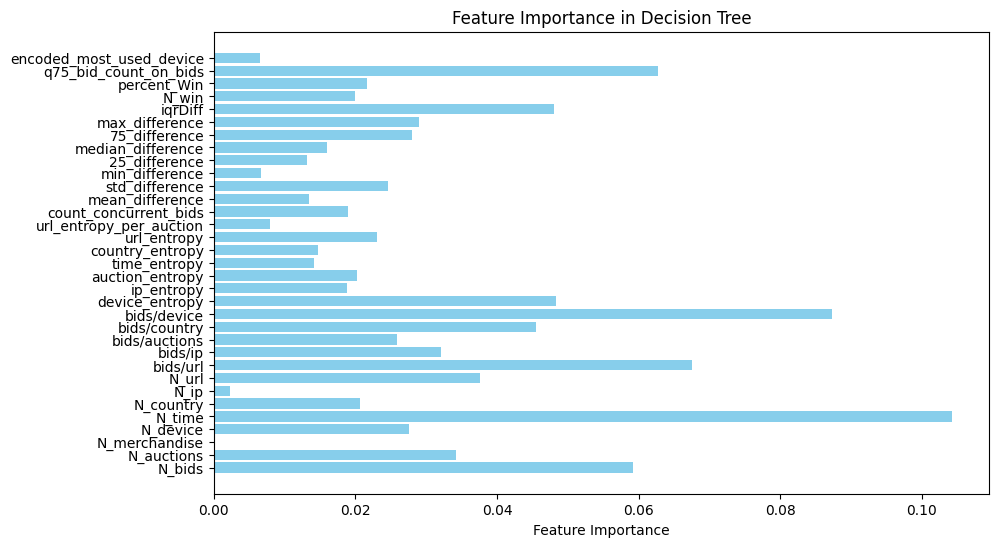

In [115]:
df = df_bidder.drop(['encoded_bidder_id'],axis=1,inplace=False)
df.columns
random_forest_features_importances(df)

According to the feature importances results we drop features that are considered completely useless

In [116]:
df2 = df.drop(['N_merchandise', 'min_difference'],axis=1, inplace=False)

## Comparison of models

In [117]:
X, y = df2.drop(columns=['outcome']), df['outcome']

### Knn

Migliori parametri: {'knn__n_neighbors': 10}


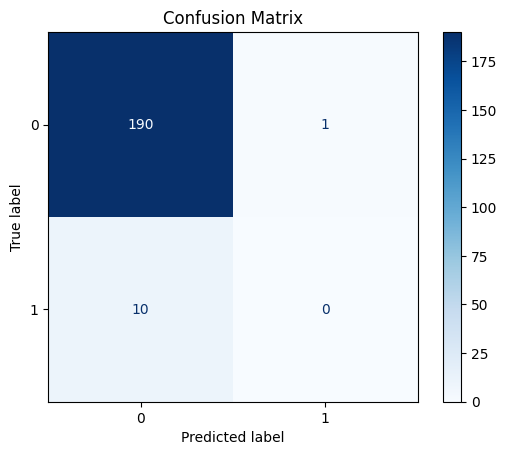

Validation AUC-ROC Score: 0.8623
Validation Recall Score: 0.0000
Validation F1 Score: 0.0000


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

pipeline = Pipeline([
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Migliori parametri:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

val_auc = roc_auc_score(y_test, y_probs)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

print(f"Validation AUC-ROC Score: {val_auc:.4f}")
print(f"Validation Recall Score: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Best Hyperparameters: {'feature_selection__k': 5, 'knn__n_neighbors': 10}


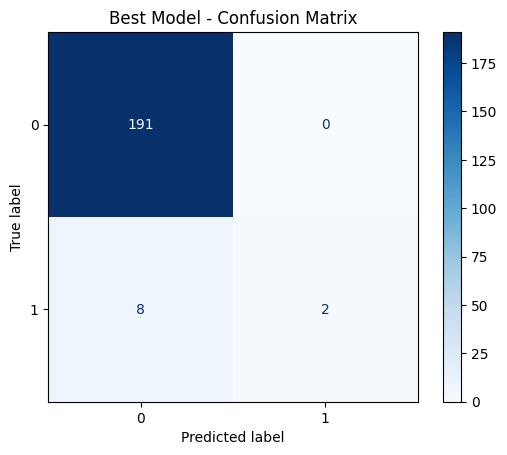

Best Validation AUC-ROC Score: 0.8458
Best Validation Recall Score: 0.2000
Best Validation F1 Score: 0.3333


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'feature_selection__k': [5, 10, 15, 20, 25, 30],
    'knn__n_neighbors': [3, 5, 7, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

y_probs = best_model.predict_proba(X_test)[:, 1] 
y_pred = best_model.predict(X_test)  

val_auc = roc_auc_score(y_test, y_probs)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format='d')
plt.title("Best Model - Confusion Matrix")
plt.show()

print(f"Best Validation AUC-ROC Score: {val_auc:.4f}")
print(f"Best Validation Recall Score: {recall:.4f}")
print(f"Best Validation F1 Score: {f1:.4f}")

### Logistic regression

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Hyperparameters: {'C': 100, 'penalty': 'l1'}


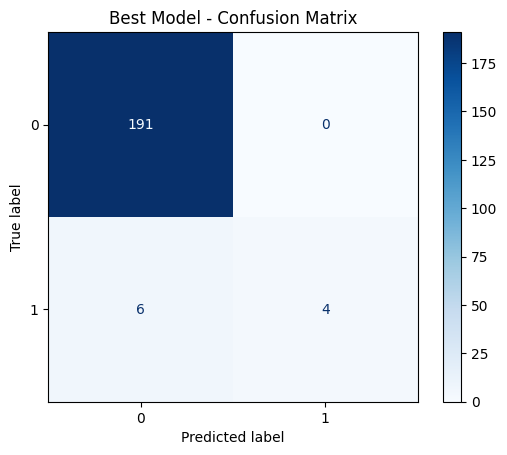

Best Validation AUC-ROC Score: 0.9204
Best Validation Recall Score: 0.4000
Best Validation F1 Score: 0.5714


In [120]:
lr = LogisticRegression(random_state=42, solver='liblinear')  

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1']  
}

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,  
    scoring='roc_auc', 
    n_jobs=-1,  
    verbose=2  
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

y_probs = best_model.predict_proba(X_test)[:, 1] 
y_pred = best_model.predict(X_test) 

val_auc = roc_auc_score(y_test, y_probs)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format='d')
plt.title("Best Model - Confusion Matrix")
plt.show()

print(f"Best Validation AUC-ROC Score: {val_auc:.4f}")
print(f"Best Validation Recall Score: {recall:.4f}")
print(f"Best Validation F1 Score: {f1:.4f}")

### Random forest

Validation AUC-ROC Score: 0.8762
Validation recall Score: 0.5000
Validation f1 Score: 0.5882


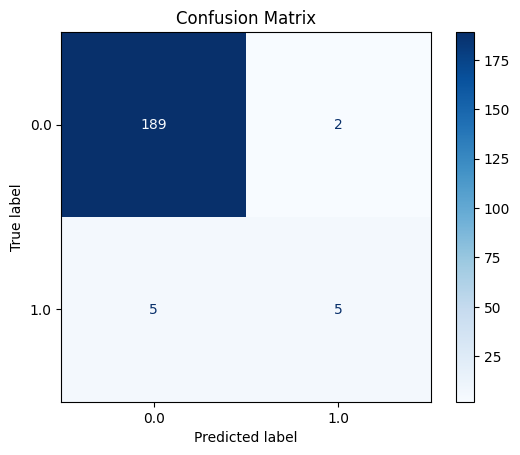

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
model = RandomForestClassifier(n_estimators=5, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)    
y_val_probs = model.predict_proba(X_test)

val_auc = roc_auc_score(y_test, y_val_probs[:, 1])
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Validation AUC-ROC Score: {val_auc:.4f}")
print(f"Validation recall Score: {recall:.4f}")
print(f"Validation f1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}
Best AUC-ROC Score from Grid Search: 0.9505


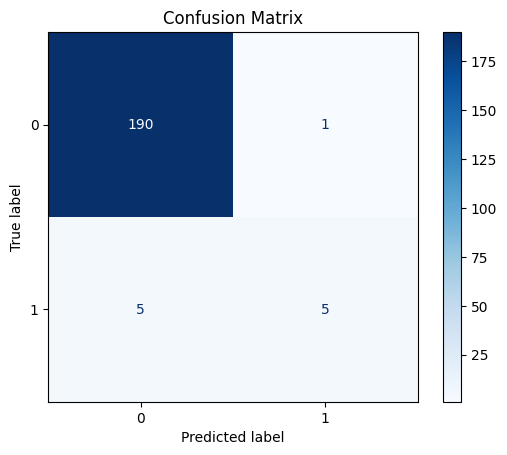

Test AUC-ROC Score: 0.9610
Test Recall Score: 0.5000
Test F1 Score: 0.6250


In [122]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [5, 10, 50, 100, 200],  # Number of trees
    'max_depth': [None, 5, 10, 20, 30],  # Maximum depth of trees
    'criterion': ['gini', 'entropy'],  # Splitting criterion
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # AUC-ROC as metric
    n_jobs=-1  # Use all processors
)

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


best_auc = grid_search.best_score_
print(f"Best AUC-ROC Score from Grid Search: {best_auc:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

val_auc = roc_auc_score(y_test, y_probs)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

print(f"Test AUC-ROC Score: {val_auc:.4f}")
print(f"Test Recall Score: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


## Working on bids dataset

### Feature extraction

As we did in the 'working on bidder' part, we extract features regarding each bidder.

In [123]:
# Add count features
count_for_bidder = bids.groupby("encoded_bidder_id").nunique().rename(columns={
    'bid_id': 'N_bids', 
    'auction': 'N_auctions', 
    'merchandise': 'N_merchandise', 
    'device': 'N_device', 
    'time': 'N_time', 
    'country': 'N_country', 
    'ip': 'N_ip', 
    'url': 'N_url'
}).reset_index()

bids = bids.merge(count_for_bidder, on="encoded_bidder_id", how="left")

# Add ratio metrics
bids['bids/url'] = bids['N_bids'] / bids['N_url']
bids['bids/ip'] = bids['N_bids'] / bids['N_ip']
bids['bids/auctions'] = bids['N_bids'] / bids['N_auctions']
bids['bids/country'] = bids['N_bids'] / bids['N_country']
bids['bids/device'] = bids['N_bids'] / bids['N_device']

In [124]:
bids.head(10)

,bid_id,auction,merchandise,device,time,country,ip,url,encoded_bidder_id,N_bids,...,N_device,N_time,N_country,N_ip,N_url,bids/url,bids/ip,bids/auctions,bids/country,bids/device
0,0,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,0,62529,...,1405,51779,122,21741,16842,3.712683,2.876087,76.069343,512.532787,44.504626
1,1,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,1,19988,...,1029,18961,153,10316,4527,4.415286,1.937573,33.649832,130.640523,19.424684
2,2,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,2,105436,...,964,82783,136,51891,13360,7.891916,2.031875,130.328801,775.264706,109.373444
3,3,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,3,10956,...,505,10679,64,6296,2479,4.419524,1.740152,58.276596,171.187500,21.695050
4,4,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,4,12888,...,635,12499,76,9240,1781,7.236384,1.394805,73.227273,169.578947,20.296063
5,5,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,5,30062,...,403,27969,125,20492,295,101.905085,1.467012,38.198221,240.496000,74.595533
6,6,kjlzx,mobile,phone2,9759243210526315,th,152.235.155.159,j9nl1xmo6fqhcc6,6,893,...,170,892,25,741,329,2.714286,1.205128,4.022523,35.720000,5.252941
7,7,f5f6k,home goods,phone8,9759243210526315,id,3.210.112.183,hnt6hu93a3z1cpc,7,6,...,4,6,1,6,3,2.000000,1.000000,1.000000,6.000000,1.500000
8,8,h7jjx,home goods,phone9,9759243210526315,th,103.64.157.225,vasstdc27m7nks3,8,3599,...,341,3569,17,3149,13,276.846154,1.142903,16.066964,211.705882,10.554252
9,9,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,9,192565,...,2020,122781,76,53405,36518,5.273153,3.605749,257.439840,2533.750000,95.329208


Add the 'average bids for each bidder' and all the features regarding entropy calculated previously 

In [125]:
# Label Encoding for url
encoder = LabelEncoder()
bids["url"] = encoder.fit_transform(bids['url'])

# From the bids dataset, group by bidder_id and url and count number of bids for every group
bids_per_url = bids.groupby(['encoded_bidder_id', 'url'])['bid_id'].count().reset_index(name='bid_count')

# Calculate the mean
average_bids_per_user = bids_per_url.groupby('encoded_bidder_id')['bid_count'].mean().reset_index(name='avg_bids_per_url')

In [126]:
bids = bids.merge(final_entropy_df, on="encoded_bidder_id", how="left")
bids = bids.merge(bids_per_auction_url_entropy, on="encoded_bidder_id", how="left")
bids = bids.merge(average_bids_per_user, on="encoded_bidder_id", how="left")
bids

,bid_id,auction,merchandise,device,time,country,ip,url,encoded_bidder_id,N_bids,...,bids/country,bids/device,device_entropy,ip_entropy,auction_entropy,time_entropy,country_entropy,url_entropy,url_entropy_per_auction,avg_bids_per_url
0,0,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,1553590,0,62529,...,512.532787,44.504626,7.119131,11.751657,6.158347,15.564985,4.504761,7.826808,6.158347,3.712683
1,1,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,974753,1,19988,...,130.640523,19.424684,7.048098,12.056797,5.696760,14.181834,4.332994,5.759340,5.696760,4.415286
2,2,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,1553590,2,105436,...,775.264706,109.373444,6.606346,13.879201,6.494542,16.221992,5.014989,2.592056,6.494542,7.891916
3,3,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,1553590,3,10956,...,171.187500,21.695050,6.631897,11.369329,2.407953,13.368523,1.020996,8.684601,2.407953,4.419524
4,4,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,1553590,4,12888,...,169.578947,20.296063,6.526911,12.235218,2.440489,13.592906,0.913703,5.753977,2.440489,7.236384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656329,7656329,3e64w,jewelry,phone91,9709222052631578,ru,140.204.227.63,618333,2957,87547,...,572.202614,80.244730,7.391259,11.872944,5.686605,16.153797,3.739519,14.905204,5.686605,1.192462
7656330,7656330,xn0y0,mobile,phone236,9709222052631578,pl,24.232.159.118,1610649,3380,3088,...,88.228571,8.530387,7.068078,10.067299,5.742580,11.580151,2.566942,8.522033,5.742580,1.966879
7656331,7656331,gja6c,sporting goods,phone80,9709222052631578,za,80.237.28.246,294671,2955,515033,...,5255.438776,196.727655,7.173412,10.848912,7.337911,17.884008,3.219659,7.318048,7.337911,6.329053
7656332,7656332,hmwk8,jewelry,phone349,9709222052631578,my,91.162.27.152,570553,3049,29125,...,970.833333,22.683022,8.011949,11.987293,3.436178,14.747362,2.956435,9.601386,3.436178,2.949666


### Features concerning single bid

Time_since_last_bid: time expired from the previous bid inside the same auction

In [127]:
# Order bids by encoded_bidder_id, auction, and then by time
bids_ordered_by_time = bids.sort_values(by=['encoded_bidder_id', 'auction', 'time'])

# Calculate the difference between every bids in the same auction for each bidder
bids_ordered_by_time['time_since_last_bid'] = bids_ordered_by_time.groupby(['encoded_bidder_id', 'auction'])['time'].diff()

# First bid has Nan value, because it is the starting bid
bids_ordered_by_time['time_since_last_bid'] = bids_ordered_by_time['time_since_last_bid'].fillna(0)

# Maintain only the new column
bids_ordered_by_time = bids_ordered_by_time[['bid_id', 'time_since_last_bid']]

print("BIDS ORDERED BY TIME DATASET SHAPE: " + str(bids_ordered_by_time.shape))

BIDS ORDERED BY TIME DATASET SHAPE: (7656334, 2)


Time until auction end: calculate the time between the actual bid and the end of the auction (end of auction = time of last bid of the auction)

In [128]:
# Group every bids by auction and take the max of the time as the end of the auction
auction_end_times = bids.groupby('auction')['time'].max().reset_index()
auction_end_times.rename(columns={'time': 'auction_end_time'}, inplace=True)
print("AUCTION END TIMES DATASET SHAPE: " + str(auction_end_times.shape))

# Merge on auction
bids_from_auction_end = bids.merge(auction_end_times, on='auction', how='left')
print("BIDS END TIMES DATASET SHAPE: " + str(bids_from_auction_end.shape))

# Calculate the distance from the last bid in the auction
bids_from_auction_end = bids_from_auction_end[['bid_id', 'auction_end_time', 'time']]
bids_from_auction_end['time_until_auction_end'] = bids_from_auction_end['auction_end_time'] - bids_from_auction_end['time']

# Drop 'auction_end_time' column
bids_from_auction_end = bids_from_auction_end.drop(['auction_end_time', 'time'], axis=1)

bids_from_auction_end

AUCTION END TIMES DATASET SHAPE: (15051, 2)
BIDS END TIMES DATASET SHAPE: (7656334, 31)


,bid_id,time_until_auction_end
0,0,13631052631579
1,1,13641842105264
2,2,13638473684211
3,3,13642052631579
4,4,13642052631579
...,...,...
7656329,7656329,0
7656330,7656330,0
7656331,7656331,0
7656332,7656332,0


Bidding speed: difference of time between the bids of a same bidder inside an auction.

In [129]:
# Sort by time within each bidder and auction
bids_sorted_per_time = bids.sort_values(by=['encoded_bidder_id', 'auction', 'time'])

# Compute bidding speed
bids_sorted_per_time['bidding_speed'] = bids_sorted_per_time.groupby(['encoded_bidder_id', 'auction'])['time'].diff().fillna(0)

# Print dataset shape
print("BIDS 'BIDDING SPEED' DATASET SHAPE: " + str(bids_sorted_per_time.shape))
bids_sorted_per_time = bids_sorted_per_time[['bid_id', 'bidding_speed']]
bids_sorted_per_time

BIDS 'BIDDING SPEED' DATASET SHAPE: (7656334, 31)


,bid_id,bidding_speed
188711,188711,0.000000e+00
524790,524790,2.400211e+12
690113,690113,1.074947e+12
906485,906485,8.814211e+11
1297288,1297288,2.650737e+12
...,...,...
7635939,7635939,0.000000e+00
7637097,7637097,0.000000e+00
7639758,7639758,0.000000e+00
7651414,7651414,0.000000e+00


Concurrent bids:'1' if a bidder is placed at the same of another, '0' otherwise.

In [130]:
print("UNIQUE VALUES OF TIME: " + str(bids['time'].nunique()))

concurrent_bids = bids.copy()

# Count how many bids have been made in the same time, respect to the auction
concurrent_bids['concurrent_bid'] = bids.groupby(['time', 'encoded_bidder_id'])['bid_id'].transform('count')

# if at least 2 cuncurrent bids, concurrent_bid = 1, else 0
concurrent_bids['concurrent_bid'] = (concurrent_bids['concurrent_bid'] > 1).astype(int)

concurrent_bids = concurrent_bids[['bid_id', 'concurrent_bid']]
concurrent_bids

UNIQUE VALUES OF TIME: 776529


,bid_id,concurrent_bid
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7656329,7656329,0
7656330,7656330,0
7656331,7656331,0
7656332,7656332,0


Winning bid in an auction: if a bid is the last of an auction, is the winning one (1), else no (0).

In [131]:
winning_bids = bids.sort_values(by=['auction', 'time'])

# Take the last bid for every auction
max_times = winning_bids.groupby('auction')['time'].transform('max')

# If is the last 1, else 0
winning_bids['winning_bid'] = (winning_bids['time'] == max_times).astype(int)

winning_bids = winning_bids[['bid_id', 'winning_bid']]
winning_bids

,bid_id,winning_bid
5826422,5826422,0
5834284,5834284,0
5850448,5850448,0
5884054,5884054,0
5898318,5898318,0
...,...,...
7646305,7646305,0
7648070,7648070,0
7648153,7648153,0
7649363,7649363,0


Percentile, quartile

In [132]:
# Calculate quantilies 
quantiles = bids.groupby('auction')['time'].quantile([0.5, 0.75]).unstack()
quantiles.columns = ['median_time', 'q3_time']

bids_quantilies = bids.merge(quantiles, on='auction', how='left')

# Creare le colonne di classificazione
bids_quantilies['first_half'] = (bids_quantilies['time'] <= bids_quantilies['median_time']).astype(int)
bids_quantilies['third_quartile'] = (bids_quantilies['time'] > bids_quantilies['q3_time']).astype(int)

# Create new dataset
bids_quantilies = bids_quantilies[['bid_id', 'first_half', 'third_quartile']]
bids_quantilies

,bid_id,first_half,third_quartile
0,0,1,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0
...,...,...,...
7656329,7656329,0,1
7656330,7656330,0,1
7656331,7656331,0,1
7656332,7656332,0,1


#### Merge of the new features with the bids dataset 

In [133]:
dfs = [bids_ordered_by_time, bids_from_auction_end, bids_sorted_per_time, concurrent_bids, winning_bids, bids_quantilies]

for df_to_merge in dfs:
	bids = bids.merge(df_to_merge, on='bid_id', how='inner')
	
bids

,bid_id,auction,merchandise,device,time,country,ip,url,encoded_bidder_id,N_bids,...,url_entropy,url_entropy_per_auction,avg_bids_per_url,time_since_last_bid,time_until_auction_end,bidding_speed,concurrent_bid,winning_bid,first_half,third_quartile
0,0,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,1553590,0,62529,...,7.826808,6.158347,3.712683,0.000000e+00,13631052631579,0.000000e+00,0,0,1,0
1,1,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,974753,1,19988,...,5.759340,5.696760,4.415286,0.000000e+00,13641842105264,0.000000e+00,0,0,1,0
2,2,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,1553590,2,105436,...,2.592056,6.494542,7.891916,0.000000e+00,13638473684211,0.000000e+00,0,0,1,0
3,3,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,1553590,3,10956,...,8.684601,2.407953,4.419524,0.000000e+00,13642052631579,0.000000e+00,0,0,1,0
4,4,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,1553590,4,12888,...,5.753977,2.440489,7.236384,0.000000e+00,13642052631579,0.000000e+00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656329,7656329,3e64w,jewelry,phone91,9709222052631578,ru,140.204.227.63,618333,2957,87547,...,14.905204,5.686605,1.192462,1.963158e+10,0,1.963158e+10,0,1,0,1
7656330,7656330,xn0y0,mobile,phone236,9709222052631578,pl,24.232.159.118,1610649,3380,3088,...,8.522033,5.742580,1.966879,7.894737e+09,0,7.894737e+09,0,1,0,1
7656331,7656331,gja6c,sporting goods,phone80,9709222052631578,za,80.237.28.246,294671,2955,515033,...,7.318048,7.337911,6.329053,5.263158e+07,0,5.263158e+07,0,1,0,1
7656332,7656332,hmwk8,jewelry,phone349,9709222052631578,my,91.162.27.152,570553,3049,29125,...,9.601386,3.436178,2.949666,1.700000e+10,0,1.700000e+10,0,1,0,1


## Feature extraction regarding bids outcome

In [134]:
# Encode features and drop Nan values
encoder = LabelEncoder()
bids["merchandise"] = encoder.fit_transform(bids['merchandise'])
bids["country"] = encoder.fit_transform(bids['country'])
bids["ip"] = encoder.fit_transform(bids['ip'])
bids["device"] = encoder.fit_transform(bids['device'])

bids.dropna(inplace = True)

Merge bids and bidders dataset to obtain outcome/label for each bid

In [135]:
df_bids = pd.merge(bids, bidder, on='encoded_bidder_id', how='right')
df_bids

,bid_id,auction,merchandise,device,time,country,ip,url,encoded_bidder_id,N_bids,...,url_entropy_per_auction,avg_bids_per_url,time_since_last_bid,time_until_auction_end,bidding_speed,concurrent_bid,winning_bid,first_half,third_quartile,outcome
0,85371.0,yitr4,5.0,2774.0,9.759489e+15,93.0,2139446.0,1553590.0,1309,24.0,...,4.053509,24.0,0.000000e+00,1.083289e+13,0.000000e+00,0.0,0.0,1.0,0.0,0.0
1,274487.0,btpyy,5.0,8.0,9.760249e+15,196.0,1045158.0,1553590.0,1309,24.0,...,4.053509,24.0,0.000000e+00,1.246726e+13,0.000000e+00,0.0,0.0,1.0,0.0,0.0
2,527436.0,kj2ko,5.0,3323.0,9.762261e+15,93.0,1222776.0,1553590.0,1309,24.0,...,4.053509,24.0,0.000000e+00,1.062200e+13,0.000000e+00,0.0,0.0,1.0,0.0,0.0
3,554135.0,1m5t8,5.0,3323.0,9.762431e+15,93.0,1639466.0,1553590.0,1309,24.0,...,4.053509,24.0,0.000000e+00,1.045411e+13,0.000000e+00,0.0,0.0,1.0,0.0,0.0
4,607628.0,btpyy,5.0,3323.0,9.762789e+15,93.0,1049309.0,1553590.0,1309,24.0,...,4.053509,24.0,2.540316e+12,9.926947e+12,2.540316e+12,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071248,609792.0,jefix,7.0,2398.0,9.762802e+15,81.0,1596435.0,533725.0,2209,2.0,...,-0.000000,2.0,0.000000e+00,1.008316e+13,0.000000e+00,0.0,0.0,1.0,0.0,0.0
3071249,2297899.0,jefix,7.0,2553.0,9.772601e+15,81.0,635465.0,533725.0,2209,2.0,...,-0.000000,2.0,9.798474e+12,2.846842e+11,9.798474e+12,0.0,0.0,0.0,1.0,0.0
3071250,3400601.0,jqx39,8.0,113.0,9.636754e+15,156.0,1858187.0,618126.0,5380,1.0,...,-0.000000,1.0,0.000000e+00,7.246758e+13,0.000000e+00,0.0,0.0,1.0,0.0,0.0
3071251,2007255.0,ntjde,6.0,5385.0,9.770756e+15,154.0,2104805.0,480909.0,2856,2.0,...,-0.000000,2.0,0.000000e+00,2.094105e+12,0.000000e+00,0.0,0.0,1.0,0.0,0.0


In [140]:
# Check for null
for column_train in df_bids.columns:
	if df_bids[column_train].isnull().sum() > 0:
		print("!NULL! " + str(df_bids[column_train].isnull().sum()))

!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29
!NULL! 29


According to the result, we fill the Nan values with zero for the bidders who do not place a bid.

In [143]:
df_bids.fillna(0, inplace=True)

Calculate probability for a device/ip/url to be used by a bot.

In [145]:
# Function to calculate bot probability based on a given feature (device, url, or ip)
def calculate_feature_bot_probability(bids, feature):
	# Count total bids per feature (device, url, or ip)
	feature_total_bids = bids.groupby(feature)["bid_id"].count().reset_index()
	feature_total_bids = feature_total_bids.rename(columns={"bid_id": "total_bids"})

	# Count bot bids per feature (where outcome == 1)
	feature_bot_bids = bids[bids["outcome"] == 1].groupby(feature)["bid_id"].count().reset_index()
	feature_bot_bids = feature_bot_bids.rename(columns={"bid_id": "bot_bids"})

	# Merge total bids and bot bids
	feature_prob = feature_total_bids.merge(feature_bot_bids, on=feature, how="left").fillna(0)

	# Compute probability: P(bot | feature) = bot_bids / total_bids
	feature_prob[f"{feature}_bot_probability"] = feature_prob["bot_bids"] / feature_prob["total_bids"]

	# Merge back into original dataset
	bids = bids.merge(feature_prob[[feature, f"{feature}_bot_probability"]], on=feature, how="left")
	
	return bids

# Apply the function to df_train for "device", "url", and "ip"
df_bids = calculate_feature_bot_probability(df_bids, "device")
df_bids = calculate_feature_bot_probability(df_bids, "url")
df_bids = calculate_feature_bot_probability(df_bids, "ip")
df_bids = calculate_feature_bot_probability(df_bids, "auction")
df_bids = calculate_feature_bot_probability(df_bids, "merchandise")
df_bids = calculate_feature_bot_probability(df_bids, "country")

# Show the results for both datasets
print(df_bids.head())

     bid_id auction  merchandise  device          time  country         ip  \
0   85371.0   yitr4          5.0  2774.0  9.759489e+15     93.0  2139446.0   
1  274487.0   btpyy          5.0     8.0  9.760249e+15    196.0  1045158.0   
2  527436.0   kj2ko          5.0  3323.0  9.762261e+15     93.0  1222776.0   
3  554135.0   1m5t8          5.0  3323.0  9.762431e+15     93.0  1639466.0   
4  607628.0   btpyy          5.0  3323.0  9.762789e+15     93.0  1049309.0   

         url  encoded_bidder_id  N_bids  ...  winning_bid  first_half  \
0  1553590.0               1309    24.0  ...          0.0         1.0   
1  1553590.0               1309    24.0  ...          0.0         1.0   
2  1553590.0               1309    24.0  ...          0.0         1.0   
3  1553590.0               1309    24.0  ...          0.0         1.0   
4  1553590.0               1309    24.0  ...          0.0         1.0   

   third_quartile  outcome  device_bot_probability  url_bot_probability  \
0             0.0

Drop useless features

## Comparison models

In [146]:
df_bids.drop(["bid_id", "time", "merchandise", "country", "ip", "device", "url", "auction"], axis=1, inplace=True)

In [209]:
X = df_bids.drop(['outcome'],axis=1)
y = df_bids['outcome']
bidder_id = X['encoded_bidder_id']
X.drop(['encoded_bidder_id'],axis=1, inplace=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

n_components = [0.80, 0.90, 0.95]

pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X)

df_pca1 = pd.concat([pd.DataFrame(X_pca), y], axis=1)	
df_pca1['encoded_bidder_id'] = bidder_id


pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

df_pca2 = pd.concat([pd.DataFrame(X_pca), y], axis=1)	
df_pca2['encoded_bidder_id'] = bidder_id



pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

df_pca3 = pd.concat([pd.DataFrame(X_pca), y], axis=1)	
df_pca3['encoded_bidder_id'] = bidder_id

In [210]:
df_pca1

,0,1,2,3,4,5,6,7,8,outcome,encoded_bidder_id
0,5.415730,-0.671240,3.533373,-1.245176,0.197077,-0.045288,0.776072,-1.316091,-0.239449,0.0,1309
1,5.449259,-0.594113,3.455339,-1.330720,0.258227,-0.040503,0.699086,-1.347448,-0.238768,0.0,1309
2,5.481755,-0.545829,3.396162,-1.349971,0.299595,-0.069134,0.690663,-1.272344,-0.217652,0.0,1309
3,5.445685,-0.612192,3.468247,-1.288968,0.244628,-0.059222,0.736590,-1.292959,-0.229152,0.0,1309
4,5.484700,-0.649648,3.474992,-0.877114,0.864790,0.399175,0.795846,-1.311746,-0.252949,0.0,1309
...,...,...,...,...,...,...,...,...,...,...,...
3071248,7.684948,1.225197,5.012503,-3.574557,2.165235,-0.721668,1.883701,-0.688648,-0.260265,0.0,2209
3071249,7.642273,0.488415,5.487177,-0.223752,4.814116,-1.056319,3.324450,-0.214714,-0.523765,0.0,2209
3071250,7.891500,0.775155,5.726526,-3.710787,1.320851,0.289547,2.892780,-0.488841,-0.109278,0.0,5380
3071251,7.905217,0.800450,5.638040,-2.942142,1.556122,-0.682245,2.765535,-0.549304,-0.221133,0.0,2856


In [211]:
df_pca2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,outcome,encoded_bidder_id
0,5.415730,-0.671240,3.533373,-1.245176,0.197077,-0.045288,0.776072,-1.316091,-0.239449,1.050798,2.276111,1.684384,-0.527823,-0.046217,0.0,1309
1,5.449259,-0.594113,3.455339,-1.330720,0.258227,-0.040503,0.699086,-1.347448,-0.238768,1.070422,2.203982,1.684952,-0.530446,-0.033234,0.0,1309
2,5.481755,-0.545829,3.396162,-1.349971,0.299595,-0.069134,0.690663,-1.272344,-0.217652,0.989221,2.197229,1.775268,-0.510688,-0.102808,0.0,1309
3,5.445685,-0.612192,3.468247,-1.288968,0.244628,-0.059222,0.736590,-1.292959,-0.229152,1.018909,2.244794,1.724840,-0.517986,-0.072985,0.0,1309
4,5.484700,-0.649648,3.474992,-0.877114,0.864790,0.399175,0.795846,-1.311746,-0.252949,1.036137,2.223499,1.727364,-0.504932,-0.091663,0.0,1309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071248,7.684948,1.225197,5.012503,-3.574557,2.165235,-0.721668,1.883701,-0.688648,-0.260265,1.103751,2.119500,1.817743,-0.608200,-0.053037,0.0,2209
3071249,7.642273,0.488415,5.487177,-0.223752,4.814116,-1.056319,3.324450,-0.214714,-0.523765,0.984870,2.029475,1.728073,-1.053786,0.893462,0.0,2209
3071250,7.891500,0.775155,5.726526,-3.710787,1.320851,0.289547,2.892780,-0.488841,-0.109278,1.306369,1.867356,3.543063,-1.461492,1.285470,0.0,5380
3071251,7.905217,0.800450,5.638040,-2.942142,1.556122,-0.682245,2.765535,-0.549304,-0.221133,1.105471,2.309740,3.644504,-0.772730,-0.384229,0.0,2856


In [212]:
df_pca3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,outcome,encoded_bidder_id
0,5.415730,-0.671240,3.533373,-1.245176,0.197077,-0.045288,0.776072,-1.316091,-0.239449,1.050798,2.276111,1.684384,-0.527823,-0.046217,-0.191397,-0.239892,-0.103754,0.0,1309
1,5.449259,-0.594113,3.455339,-1.330720,0.258227,-0.040503,0.699086,-1.347448,-0.238768,1.070422,2.203982,1.684952,-0.530446,-0.033234,-0.308396,-0.038599,-0.036281,0.0,1309
2,5.481755,-0.545829,3.396162,-1.349971,0.299595,-0.069134,0.690663,-1.272344,-0.217652,0.989221,2.197229,1.775268,-0.510688,-0.102808,-0.341814,0.175927,0.002300,0.0,1309
3,5.445685,-0.612192,3.468247,-1.288968,0.244628,-0.059222,0.736590,-1.292959,-0.229152,1.018909,2.244794,1.724840,-0.517986,-0.072985,-0.255972,-0.077627,-0.060612,0.0,1309
4,5.484700,-0.649648,3.474992,-0.877114,0.864790,0.399175,0.795846,-1.311746,-0.252949,1.036137,2.223499,1.727364,-0.504932,-0.091663,-0.264732,-0.037980,-0.069614,0.0,1309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071248,7.684948,1.225197,5.012503,-3.574557,2.165235,-0.721668,1.883701,-0.688648,-0.260265,1.103751,2.119500,1.817743,-0.608200,-0.053037,0.201737,-0.147527,0.200079,0.0,2209
3071249,7.642273,0.488415,5.487177,-0.223752,4.814116,-1.056319,3.324450,-0.214714,-0.523765,0.984870,2.029475,1.728073,-1.053786,0.893462,0.490320,0.351248,0.245072,0.0,2209
3071250,7.891500,0.775155,5.726526,-3.710787,1.320851,0.289547,2.892780,-0.488841,-0.109278,1.306369,1.867356,3.543063,-1.461492,1.285470,0.148644,1.208884,1.058164,0.0,5380
3071251,7.905217,0.800450,5.638040,-2.942142,1.556122,-0.682245,2.765535,-0.549304,-0.221133,1.105471,2.309740,3.644504,-0.772730,-0.384229,0.476463,0.801768,0.283137,0.0,2856


In [213]:
X_bidder = bidder.drop(['outcome'],axis=1)
y_bidder = bidder['outcome']

X_train_bidder, X_test_bidder, y_train_bidder, y_test_bidder = train_test_split(X_bidder, y_bidder, test_size=0.3, random_state=42, stratify=y_bidder)
X_train_bidder, X_val_bidder, y_train_bidder, y_val_bidder = train_test_split(X_train_bidder, y_train_bidder, test_size=0.4, random_state=42, stratify=y_train_bidder)

PCA 0.80

In [222]:
df_train = pd.merge(df_pca1, X_train_bidder, on='encoded_bidder_id', how='inner')
df_val = pd.merge(df_pca1, X_val_bidder, on='encoded_bidder_id', how='inner')
df_test = pd.merge(df_pca1, X_test_bidder, on='encoded_bidder_id', how='inner')

Random forest

ROC AUC Score for variance 0.80: 0.9359
Classification Report for variance 0.80:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    497670
         1.0       0.85      0.73      0.79     76798

    accuracy                           0.95    574468
   macro avg       0.91      0.86      0.88    574468
weighted avg       0.95      0.95      0.95    574468



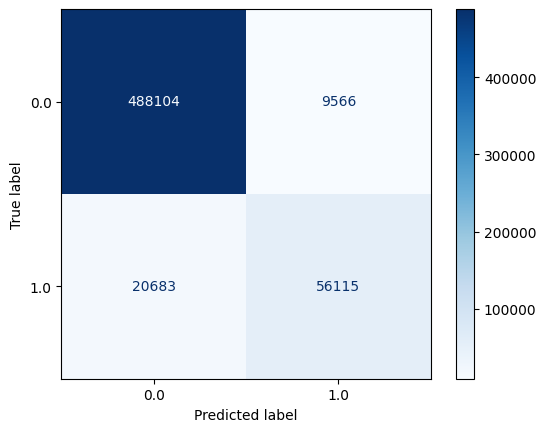

In [223]:
X_train, y_train = df_train.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_train['outcome']
X_val, y_val = df_val.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_val['outcome']

model = RandomForestClassifier(n_estimators=5, random_state=42)
model.fit(X_train, y_train)  # Assuming y_train is the target variable for training
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs[:, 1])  # Assuming y_val is the target variable for validation
print(f"ROC AUC Score for variance 0.80: {roc_auc:.4f}")

cr_new_features = classification_report(y_val, y_pred)
print(f"Classification Report for variance 0.80:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

Logistic regression

ROC AUC Score for variance 0.80: 0.9887
Classification Report for variance 0.80:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    497670
         1.0       0.89      0.91      0.90     76798

    accuracy                           0.97    574468
   macro avg       0.94      0.95      0.94    574468
weighted avg       0.97      0.97      0.97    574468



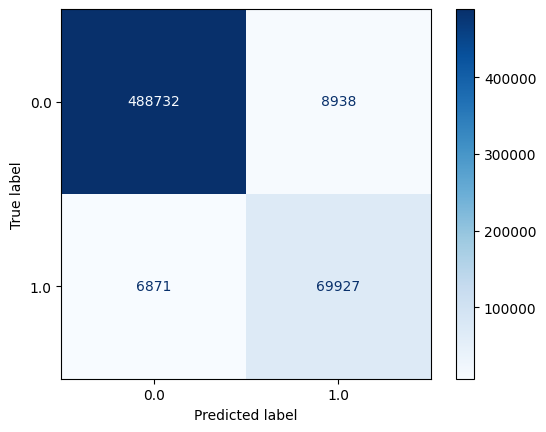

In [224]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Assuming y_train is the target variable for training
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs[:, 1])  # Assuming y_val is the target variable for validation
print(f"ROC AUC Score for variance 0.80: {roc_auc:.4f}")

cr_new_features = classification_report(y_val, y_pred)
print(f"Classification Report for variance 0.80:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

PCA 0.90

In [225]:
df_train = pd.merge(df_pca2, X_train_bidder, on='encoded_bidder_id', how='inner')
df_val = pd.merge(df_pca2, X_val_bidder, on='encoded_bidder_id', how='inner')
df_test = pd.merge(df_pca2, X_test_bidder, on='encoded_bidder_id', how='inner')

Random forest

ROC AUC Score for variance 0.90: 0.9003
Classification Report for variance 0.90:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94    497670
         1.0       0.64      0.57      0.60     76798

    accuracy                           0.90    574468
   macro avg       0.79      0.76      0.77    574468
weighted avg       0.89      0.90      0.90    574468



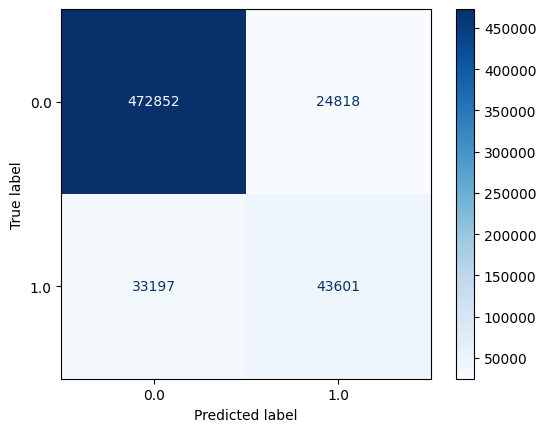

In [226]:
X_train, y_train = df_train.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_train['outcome']
X_val, y_val = df_val.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_val['outcome']

model = RandomForestClassifier(n_estimators=5, random_state=42)
model.fit(X_train, y_train)  # Assuming y_train is the target variable for training
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs[:, 1])  # Assuming y_val is the target variable for validation
print(f"ROC AUC Score for variance 0.90: {roc_auc:.4f}")

cr_new_features = classification_report(y_val, y_pred)
print(f"Classification Report for variance 0.90:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

Logistic regression with pca variance 0.90

ROC AUC Score for variance 0.90: 0.9936
Classification Report for variance 0.90:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    497670
         1.0       0.94      0.94      0.94     76798

    accuracy                           0.98    574468
   macro avg       0.96      0.96      0.96    574468
weighted avg       0.98      0.98      0.98    574468



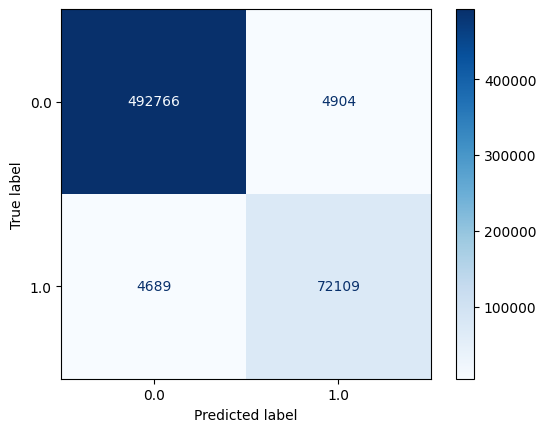

In [227]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Assuming y_train is the target variable for training
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs[:, 1])  # Assuming y_val is the target variable for validation
print(f"ROC AUC Score for variance 0.90: {roc_auc:.4f}")

cr_new_features = classification_report(y_val, y_pred)
print(f"Classification Report for variance 0.90:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

PCA 0.95

In [238]:
df_train = pd.merge(df_pca3, X_train_bidder, on='encoded_bidder_id', how='inner')
df_val = pd.merge(df_pca3, X_val_bidder, on='encoded_bidder_id', how='inner')
df_test = pd.merge(df_pca3, X_test_bidder, on='encoded_bidder_id', how='inner')

Random forest with pca variance 0.95

ROC AUC Score for variance 0.95: 0.9199
Classification Report for variance 0.95:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    497670
         1.0       0.82      0.73      0.77     76798

    accuracy                           0.94    574468
   macro avg       0.89      0.85      0.87    574468
weighted avg       0.94      0.94      0.94    574468



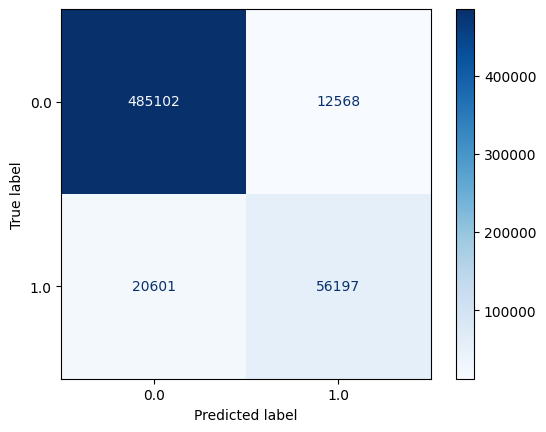

In [239]:
X_train, y_train = df_train.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_train['outcome']
X_val, y_val = df_val.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_val['outcome']

model = RandomForestClassifier(n_estimators=5, random_state=42)
model.fit(X_train, y_train)  # Assuming y_train is the target variable for training
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs[:, 1])  # Assuming y_val is the target variable for validation
print(f"ROC AUC Score for variance 0.95: {roc_auc:.4f}")

cr_new_features = classification_report(y_val, y_pred)
print(f"Classification Report for variance 0.95:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

Logistic regression with pca variance 0.95

ROC AUC Score for variance 0.95: 0.9937
Classification Report for variance 0.95:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    497670
         1.0       0.94      0.94      0.94     76798

    accuracy                           0.98    574468
   macro avg       0.97      0.96      0.96    574468
weighted avg       0.98      0.98      0.98    574468



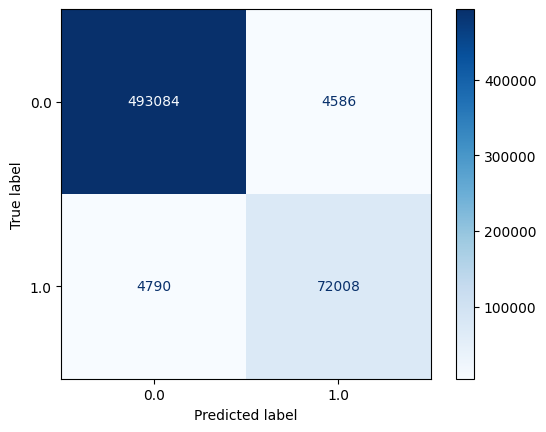

In [241]:
model = LogisticRegression(random_state=42, C=0.1)
model.fit(X_train, y_train)  # Assuming y_train is the target variable for training
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_probs[:, 1])  # Assuming y_val is the target variable for validation
print(f"ROC AUC Score for variance 0.95: {roc_auc:.4f}")

cr_new_features = classification_report(y_val, y_pred)
print(f"Classification Report for variance 0.95:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

### According to the result, we select Logistic Regression with PCA variance of 0.95% as the best model.

Use test data 

ROC AUC Score for test: 0.9770
Classification Report for test:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    820412
         1.0       0.66      0.90      0.76     53159

    accuracy                           0.97    873571
   macro avg       0.82      0.93      0.87    873571
weighted avg       0.97      0.97      0.97    873571



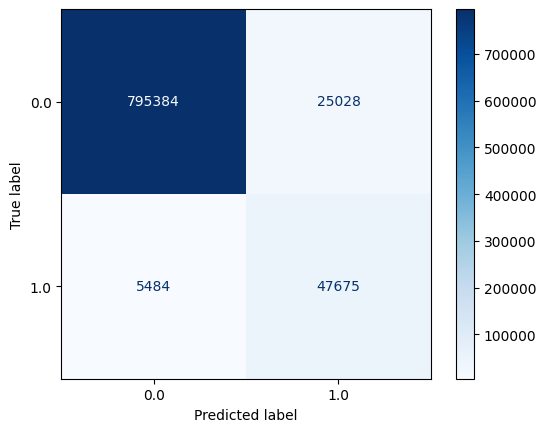

In [242]:
X_test, y_test = df_test.drop(['outcome','encoded_bidder_id'], axis=1, inplace=False), df_test['outcome']

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs[:, 1]) 
print(f"ROC AUC Score for test: {roc_auc:.4f}")

cr_new_features = classification_report(y_test, y_pred)
print(f"Classification Report for test:")
print(cr_new_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm_dt_with_new_features = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cm_dt_with_new_features.plot(cmap="Blues", values_format='d')

In [243]:
df_results = pd.DataFrame({
	"encoded_bidder_id": df_test["encoded_bidder_id"],
	"y_pred": y_pred
})
df_results

,encoded_bidder_id,y_pred
0,2397,0.0
1,2397,0.0
2,2397,0.0
3,238,0.0
4,238,0.0
...,...,...
873566,6495,0.0
873567,2209,0.0
873568,2209,0.0
873569,2856,0.0


In [244]:
bot_bids_per_bidder = df_results.groupby("encoded_bidder_id")["y_pred"].value_counts().unstack(fill_value=0)
bot_bids_per_bidder = bot_bids_per_bidder.rename(columns={0: "human_bids", 1: "bot_bids"}).reset_index()
bot_bids_per_bidder

y_pred,encoded_bidder_id,human_bids,bot_bids
0,13,84123,196
1,33,3368,11
2,68,34,1131
3,76,63,0
4,82,294,0
...,...,...,...
599,6629,1,0
600,6632,1,0
601,6634,1,0
602,6637,1,0


In [245]:
bot_bids_per_bidder["outcome_from_bids"] = bot_bids_per_bidder["bot_bids"] > bot_bids_per_bidder["human_bids"]
bot_bids_per_bidder["outcome_from_bids"] = bot_bids_per_bidder["outcome_from_bids"].astype(int)
bot_bids_per_bidder

y_pred,encoded_bidder_id,human_bids,bot_bids,outcome_from_bids
0,13,84123,196,0
1,33,3368,11,0
2,68,34,1131,1
3,76,63,0,0
4,82,294,0,0
...,...,...,...,...
599,6629,1,0,0
600,6632,1,0,0
601,6634,1,0,0
602,6637,1,0,0


In [246]:
df_compare = bidder.merge(bot_bids_per_bidder, on="encoded_bidder_id", how="inner").fillna(0)
df_compare["outcome_match"] = (df_compare["outcome"] == (df_compare["outcome_from_bids"] > 0).astype(int))
df_compare

,outcome,encoded_bidder_id,human_bids,bot_bids,outcome_from_bids,outcome_match
0,0.0,2397,3,0,0,True
1,0.0,238,155,0,0,True
2,0.0,5346,2,0,0,True
3,0.0,4987,2,0,0,True
4,0.0,6557,2,0,0,True
...,...,...,...,...,...,...
599,0.0,4024,39,0,0,True
600,0.0,6360,1,0,0,True
601,0.0,6495,1,0,0,True
602,0.0,2209,2,0,0,True


In [ ]:
# Conta i casi in cui entrambi sono 1
Tp = ((df_compare["outcome"] == 1) & (df_compare["outcome_from_bids"] > 0)).sum()

Tn = ((df_compare["outcome"] == 0) & (df_compare["outcome_from_bids"] == 0)).sum()

Fp = ((df_compare["outcome"] == 0) & (df_compare["outcome_from_bids"] > 0)).sum()

Fn = ((df_compare["outcome"] == 1) & (df_compare["outcome_from_bids"] == 0)).sum()

precision = Tp/(Tp+Fp)
recall = Tp/(Tp+Fn)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {2*((precision*recall)/(precision+recall))}")


Precision: 0.9375
Recall: 0.967741935483871
F1-score: 0.9523809523809523
